# Toxic Comment Classification Challenge

This is a dataset of Comments taken from the kaggle competition that i am participating in. The aim of this competition is to classify the comments into different classes of toxicity.

The dataset comprises of one feature, that is the comment itself, and it is a multiclass classification problem, involving, assigning a probability to each of the different classes ; namely 
 - toxic
 - severe toxic
 - obscene
 - threat
 - insult
 - identity hate
 
This classification problem allows the comments to be dealt accordingly , and action on these comments could be taken accordingly.

We will start the problem by importing some of the necessary libraries, having a look at the dataset, preprocessing it, and then applying our model to it. 

So, let's start

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
from keras.layers import Input,Dense,Dropout,Activation,Conv2D,SpatialDropout1D,Embedding,LSTM,GRU,Conv1D
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Bidirectional, GlobalMaxPooling1D,GlobalAveragePooling1D,concatenate
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
import keras
import re
from collections import defaultdict

import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

from wordcloud import WordCloud ,STOPWORDS
from PIL import Image

eng_stopwords = set(stopwords.words("english"))


lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

Using TensorFlow backend.


In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
train.shape,test.shape

((159571, 8), (153164, 2))

In [6]:
print(train['comment_text'][0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


Now, that we have had a look at the dataset , we can see that the comments, do need some preprocessing , to keep only the words that matter or add value to the dataset. It seems like a big enough dataset, so it shouldn't be a problem with lack of training data.

## Preprocessing

- we start by creating a dictionary of certain words which can be replaced by their respective meanings in the english language
- We then try to impose these changes, take care of extra punctuations, white spaces, lowercase letter conversion etc, in the next step

In [9]:
repl = {
    "&lt;3": " good ",
    ":d": " good ",
    ":dd": " good ",
    ":p": " good ",
    "8)": " good ",
    ":-)": " good ",
    ":)": " good ",
    ";)": " good ",
    "(-:": " good ",
    "(:": " good ",
    "yay!": " good ",
    "yay": " good ",
    "yaay": " good ",
    "yaaay": " good ",
    "yaaaay": " good ",
    "yaaaaay": " good ",
    ":/": " bad ",
    ":&gt;": " sad ",
    ":')": " sad ",
    ":-(": " bad ",
    ":(": " bad ",
    ":s": " bad ",
    ":-s": " bad ",
    "&lt;3": " heart ",
    ":d": " smile ",
    ":p": " smile ",
    ":dd": " smile ",
    "8)": " smile ",
    ":-)": " smile ",
    ":)": " smile ",
    ";)": " smile ",
    "(-:": " smile ",
    "(:": " smile ",
    ":/": " worry ",
    ":&gt;": " angry ",
    ":')": " sad ",
    ":-(": " sad ",
    ":(": " sad ",
    ":s": " sad ",
    ":-s": " sad ",
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bhaha\b": "ha",
    r"\bhahaha\b": "ha",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bwon't\b": "will not",
    r"\bwouldn't\b": "would not",
    r"\bcan't\b": "can not",
    r"\bcannot\b": "can not",
    r"\bi'm\b": "i am",
    "m": "am",
    "r": "are",
    "u": "you",
    "haha": "ha",
    "hahaha": "ha",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "can't": "can not",
    "cannot": "can not",
    "i'm": "i am",
    "m": "am",
    "i'll" : "i will",
    "its" : "it is",
    "it's" : "it is",
    "'s" : " is",
    "that's" : "that is",
    "weren't" : "were not",
    "<3": "love",
    "im": "i am",
    "gonna":'going to',
    "lol":"laugh out loud",
    "lmao":"laugh my arse out",
    "gr8":"great"
}
keys = [i for i in repl.keys()]

In [10]:
print(repl.keys())

dict_keys(['&lt;3', ':d', ':dd', ':p', '8)', ':-)', ':)', ';)', '(-:', '(:', 'yay!', 'yay', 'yaay', 'yaaay', 'yaaaay', 'yaaaaay', ':/', ':&gt;', ":')", ':-(', ':(', ':s', ':-s', '\\br\\b', '\\bu\\b', '\\bhaha\\b', '\\bhahaha\\b', "\\bdon't\\b", "\\bdoesn't\\b", "\\bdidn't\\b", "\\bhasn't\\b", "\\bhaven't\\b", "\\bhadn't\\b", "\\bwon't\\b", "\\bwouldn't\\b", "\\bcan't\\b", '\\bcannot\\b', "\\bi'm\\b", 'm', 'r', 'u', 'haha', 'hahaha', "don't", "doesn't", "didn't", "hasn't", "haven't", "hadn't", "won't", "wouldn't", "can't", 'cannot', "i'm", "i'll", 'its', "it's", "'s", "that's", "weren't", '<3', 'im', 'gonna', 'lol', 'lmao', 'gr8'])


In [11]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[repl[word] if word in repl.keys() else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)



# Splitting the train and test data
After applying the clean preprocessing function, and checking the changes have taken place, we split the training set into its respective features and labels, also we have a look at the preprocessed testing set

In [12]:
X_train=train['comment_text'].apply(lambda x :clean(x))

In [13]:
X_train.head()

0    explanationwhy edit make username hardcore met...
1    d'aww ! match background colour i am seemingly...
2    hey man , i am really try edit war . it is guy...
3    " morei can not make real suggestions improvem...
4        , sir , hero . chance remember page that is ?
Name: comment_text, dtype: object

In [14]:
X_test=test['comment_text'].apply(lambda x: clean(x))

In [15]:
X_test.head()

0    yo bitch ja rule succesful ever whats hat sad ...
1                       = = rfc = = title fine , imo .
2         " = = source = = * zawe ashton lapland — / "
3    : look back source , information update correc...
4                    do not anonymously edit article .
Name: comment_text, dtype: object

In [16]:
labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
y_train=train[labels].values


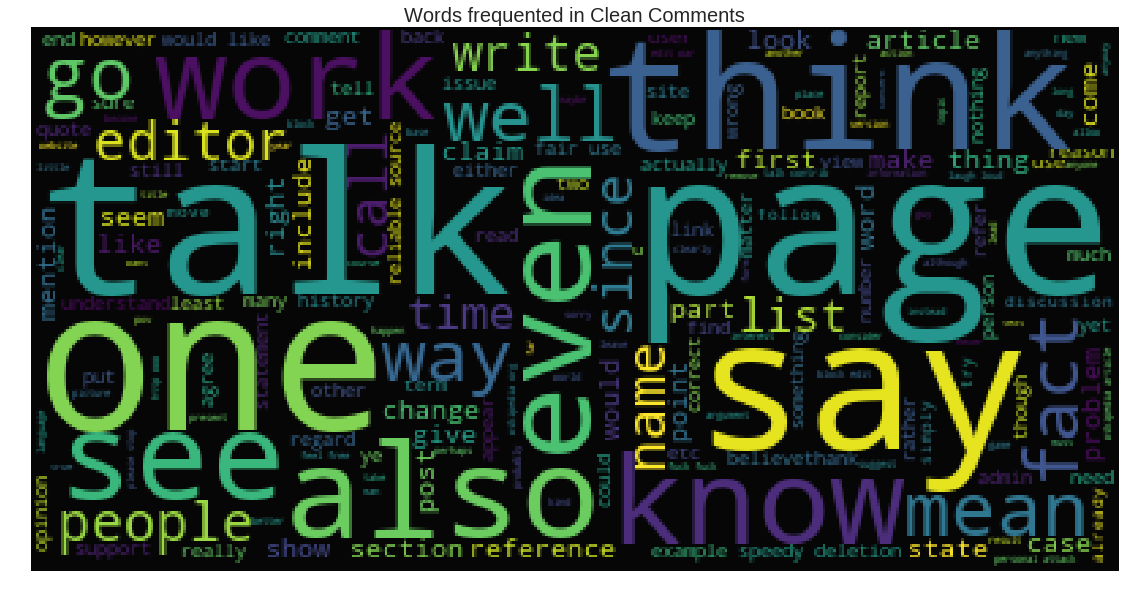

In [53]:
subset=X_train
text=subset.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

# Changing the comments in a form which can be fed into Neural Network

To let the neural network utilize the text sequences, we need to preprocess and feed it to the network ,by
- Tokenizing the sentences words, indexing the tokenized words into a dictionary ['I','am','working']
- Indexing the tokenized words into a dictionary like structure {1:'I',2:'am',3:'working'}
- Index Representation, means utilizing the number keys as sequences tand feed these chain of sequences in the LSTM model 

In [17]:
for i in range(5):
    print(list(X_train)[i])

explanationwhy edit make username hardcore metallica fan revert ? were not vandalisms , closure gas vote new york dolls fac . please do not remove template talk page since i am retire .
d'aww ! match background colour i am seemingly stick . thank . ( talk ) 21:51 , january 11 , 2016 ( utc )
hey man , i am really try edit war . it is guy constantly remove relevant information talk edit instead talk page . seem care format actual info .
" morei can not make real suggestions improvement - wonder section statistics later , subsection " " type accidents " " - think reference may need tidy exact format ie date format etc . later , no-one else first - preferences format style reference want please let know.there appear backlog article review guess may delay reviewer turn . it is list relevant form eg wikipedia : good_article_nominations #transport "
, sir , hero . chance remember page that is ?


### Describing hyperparmaters like max_features, embedding size, and timesteps, we will explain them as we come across them, we will use keras to tokenize , index using a dictionary and represent it as sequences, which will be utilized after padding

In [18]:

max_features=100000  #deciding the vocabulary size or the maximum no of possible words of dimensions possible 
tokenizer=Tokenizer(num_words=max_features) #utlilizing keras tokenizer to tokenize the preprocessed comment
tokenizer.fit_on_texts(list(X_train)) #fitting the tokenizer on X_train
sequence_list_train=tokenizer.texts_to_sequences(X_train) #indexing the fitted tokens in a dict in training set
sequence_list_test=tokenizer.texts_to_sequences(X_test) #indexing the fitted tokens in a dict in test set

In [19]:
#having a look at the indexed sequence in the first comment of the training set
sequence_list_train[0]

[86455,
 5,
 11,
 566,
 3713,
 10112,
 669,
 70,
 1863,
 3,
 9598,
 5330,
 2060,
 434,
 66,
 1077,
 13155,
 2383,
 13,
 22,
 3,
 41,
 273,
 6,
 2,
 85,
 19,
 29,
 2233]

### padding the sequences
There is one more issue to be dealt with , we need to fix a certain length of sequence which will be fed one at a time to the model , the sequences or lists which are shorter than this length will be padded with zeros, whereas longer sequences will be truncated , thereby maintaining the size of the sequence length in all cases, we do it using pad_sequences

let us say the sequence length we decided is 7,

eg1=[1,658,485] is of length 3 , but when padded, it becomes [1,685,485,0,0,0,0]

eg2=[1,2,3,755,4,589,32,54,48,952,69,946,1,5882] ,when truncated becomes [1,2,3,755,4,589,32]

so, we have to chose the sequence length as such that we cover most of the cases, without missing much info

In [20]:
#let us check the length distribution for the comments
list_len=[len(sequence_list_train[i]) for i in range(len(X_train))]


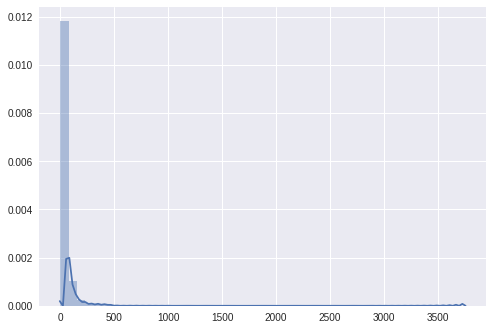

In [21]:
import seaborn as sns
sns.distplot(list_len)


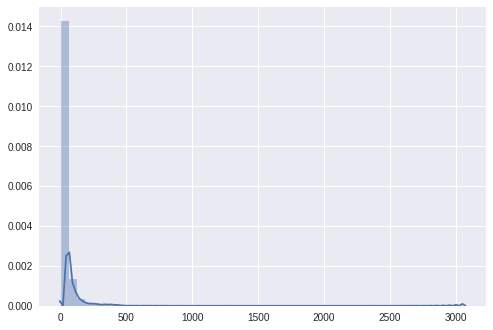

In [22]:
list_len_test=[len(sequence_list_test[i]) for i in range(len(X_test))]
sns.distplot(list_len_test)

In [23]:
#choosing 150 as the optimum length for the sequence and 300 as the embedding size as we will be using Glove 300d
maxlen=150
embed_size=300
pad_train=pad_sequences(sequence_list_train,maxlen=maxlen)
pad_test=pad_sequences(sequence_list_test,maxlen=maxlen)

In [24]:
#having a look at the first comment after padding the training and testing set
pad_train[0],len(pad_train[0])

(array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0, 86455,     5,    11,   566,  3713,
      

### Glove Embedding , embedding matrix creation

we will now use the input layer, the embedding layer , and feed it into out LSTM model, by defining the shapes and dimensions properly, if the sequence length is too small , we may miss out on accuracy, if it is large , we would need a big enough network to capture the details.

The Embedding layer will project our feature space into a lower dimensional vector space, which helps us save the computation.

let's start building the model

In [49]:
#utlizing the glove embeddings and creating an embedding matrix
EMBEDDING_FILE = '../glove.840B.300d.txt'

embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

word_index = tokenizer.word_index
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [54]:
print(embedding_matrix.dtype),embedding_matrix.shape

float64


(None, (100000, 300))

I will save this numpy array and utilize it directly for my training data as it saves me the burden of going through the above steps again.

In [55]:
np.savetxt('glove_matrix.txt',embedding_matrix)

In [25]:
embedding_matrix=np.loadtxt('glove_matrix.txt')

# Model Building
We will be utilizing keras to build a neural network using the Model API

The model consists of bidirectional LSTM and a CNN , before that , let us split the training data into training and validation set, and utilize the evaluation metric which will be using to evaluate our model,i.e Receiver Operating Chaacteristic Area under the curve

We have also used Modelcheckpoint as a callback which will save the model after every epoch 

In [26]:
from sklearn.metrics import roc_auc_score
import keras.backend as k
from sklearn.model_selection import train_test_split
from keras.callbacks import Callback
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))


X_tra, X_val, y_tra, y_val = train_test_split(pad_train, y_train, train_size=0.95, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',verbose=1, save_best_only=False)
callbacks_list = [checkpoint,RocAuc]

/home/tensor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### layer by layer explanation of the model architecture
- input layer takes input in the form on maxlen or the no of timesteps to be processed at a time
- embedding layer projects the input features to a lower dimensional vector space using glove weights which are trainable , as a result it can change when it encounters something new
- SpatialDropout is used to avoid overfitting, as it is meant to drop dimensions from an output vector/matrix 
- We then apply a bidirectional layer to an LSTM cell to capture the sequences both forward and backward, we have taken measures in this layer as well to avoid overfitting
- The output then passes to a unidimensional COnvolutional layer with valid padding which captures different aspects with different kernel weights
- We then perform a concatenation of two layers, a globalmaxpool(which takes the maximum value of the output feature map at every iteration) a global average pool( which takes average value of the output feature map at every iteration) 
- This concatenation is then passed on to a fully connected layer which uses sigmoid activation function and 6 output nodes to give 6  output probabilities to 6 labels.

In [32]:
##defining our model architecture 
def Conv_biLSTM(maxlen):
    inp=Input(shape=(maxlen,))
    x=Embedding(input_dim=max_features,output_dim=embed_size,weights=[embedding_matrix],trainable=True)(inp)
    x=SpatialDropout1D(0.35)(x)
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))(x)
    x = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])

    out = Dense(6, activation='sigmoid')(x)

    model = Model(inp, out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [33]:
model=Conv_biLSTM(maxlen)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 150)           0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 150, 300)      30000000    input_2[0][0]                    
____________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDrop (None, 150, 300)      0           embedding_2[0][0]                
____________________________________________________________________________________________________
bidirectional_2 (Bidirectional)  (None, 150, 256)      439296      spatial_dropout1d_2[0][0]        
___________________________________________________________________________________________

In [34]:
#after having a look at model parameters , let us train the model for 2 epochs and evaluate it on validation set
batch_size = 32
epochs = 2

model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, verbose=1,callbacks=callbacks_list,
          validation_data=(X_val,y_val))


Train on 151592 samples, validate on 7979 samples
Epoch 1/2
151584/151592 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9814Epoch 00000: saving model to weights-improvement-00-0.98.hdf5

 ROC-AUC - epoch: 1 - score: 0.986474 

151592/151592 [==============================] - 4934s - loss: 0.0508 - acc: 0.9814 - val_loss: 0.0472 - val_acc: 0.9823
Epoch 2/2
151584/151592 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9841Epoch 00001: saving model to weights-improvement-01-0.98.hdf5

 ROC-AUC - epoch: 2 - score: 0.988145 

151592/151592 [==============================] - 4717s - loss: 0.0402 - acc: 0.9841 - val_loss: 0.0442 - val_acc: 0.9826


We will use the weights we achieved in the second epoch as our final weights, it seems to have a decent performance on the validation set

In [35]:
model.save('conv_biLSTM_glove.hdf5')

### Let us predict the test set with our trained model and see what predictions and results we get

In [36]:
y_preds=model.predict(pad_test,batch_size=64,verbose=1)

153164/153164 [==============================] - 452s   


In [37]:
submission=pd.read_csv('sample_submission.csv')
submission[labels]=y_preds
submission.to_csv('biLSTM-conv-glove.csv',index=False)

This model achieved a score of 0.9827 in the kaggle test set, which is not bad. More things that can be tried , for eg: ensemble of different models, correlation check with different models for different labels